# Pinwheel Test

Use a moving pinwheel to test the response of our filter bank

In [1]:
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as F


torch.Size([1, 1, 80, 500, 500])


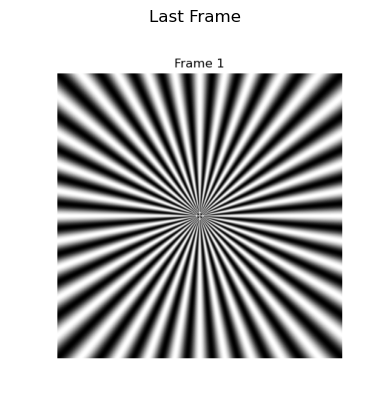

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

test_type = 'pinwheel' #'pinwheel'
n_movie_frames = 80

# Path to your AVI file
if(test_type=='pinwheel'):
    test_movie = './texture_examples/siemens_star/siemens_star_rotation.avi'
elif(test_type=='water'):
    test_movie = './texture_examples/water.mp4'

    
# Open the video file
cap = cv2.VideoCapture(test_movie)

# Check if the video opened successfully
if not cap.isOpened():
    print(f"Error: Unable to open video file '{test_movie}'")
    exit()

# Initialize list to store frames
movie = []

# Read frames from the video
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale if necessary
    if frame.ndim > 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    movie.append(frame)

# Convert list of frames to numpy array & PyTorch tensor
movie = np.array(movie)
movie = torch.from_numpy(movie)
movie = movie.unsqueeze(0)  # Add a channel dimension (for grayscale)
movie = movie.unsqueeze(0)  # Add a channel dimension (for grayscale)
# Convert to float tensor (if needed)
movie = movie.float()
#take only the first n frames of the movie
movie = movie[:,:,:n_movie_frames,:,:]

print(movie.shape)
# if(test_movie=='pinwheel'):
plt.imshow(movie[0][0][0], cmap='gray')  # Show the last frame
plt.title('Last Frame')
plt.axis('off')
plt.show()


# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


In [3]:
print(movie.shape)

torch.Size([1, 1, 80, 500, 500])


## Load in our Spatiotemporal Filter Bank

In [4]:
normalize=False
filter_banks_size = 32
with open(f'./filter_banks_norm{normalize}_{filter_banks_size}/filters_torch.pkl', 'rb') as f:
    filters = pickle.load(f)

In [5]:
filters['spatiotemporal']['im'].keys()

dict_keys(['1-0-1', '1-0-2', '1-0-4', '1-0-8', '1-45-1', '1-45-2', '1-45-4', '1-45-8', '1-90-1', '1-90-2', '1-90-4', '1-90-8', '1-135-1', '1-135-2', '1-135-4', '1-135-8', '1-180-1', '1-180-2', '1-180-4', '1-180-8', '1-225-1', '1-225-2', '1-225-4', '1-225-8', '1-270-1', '1-270-2', '1-270-4', '1-270-8', '1-315-1', '1-315-2', '1-315-4', '1-315-8', '2-0-1', '2-0-2', '2-0-4', '2-0-8', '2-45-1', '2-45-2', '2-45-4', '2-45-8', '2-90-1', '2-90-2', '2-90-4', '2-90-8', '2-135-1', '2-135-2', '2-135-4', '2-135-8', '2-180-1', '2-180-2', '2-180-4', '2-180-8', '2-225-1', '2-225-2', '2-225-4', '2-225-8', '2-270-1', '2-270-2', '2-270-4', '2-270-8', '2-315-1', '2-315-2', '2-315-4', '2-315-8', '4-0-1', '4-0-2', '4-0-4', '4-0-8', '4-45-1', '4-45-2', '4-45-4', '4-45-8', '4-90-1', '4-90-2', '4-90-4', '4-90-8', '4-135-1', '4-135-2', '4-135-4', '4-135-8', '4-180-1', '4-180-2', '4-180-4', '4-180-8', '4-225-1', '4-225-2', '4-225-4', '4-225-8', '4-270-1', '4-270-2', '4-270-4', '4-270-8', '4-315-1', '4-315-2', '4-

In [6]:
#while testing this out, only use one orientation
filter_subset = '90'
keys = filters['spatiotemporal']['im'].keys()
keys_subset = [k for k in keys if filter_subset in k]
keys_subset = [k for k in keys_subset if '1-' in k]
keys_subset

['1-90-1', '1-90-2', '1-90-4', '1-90-8']

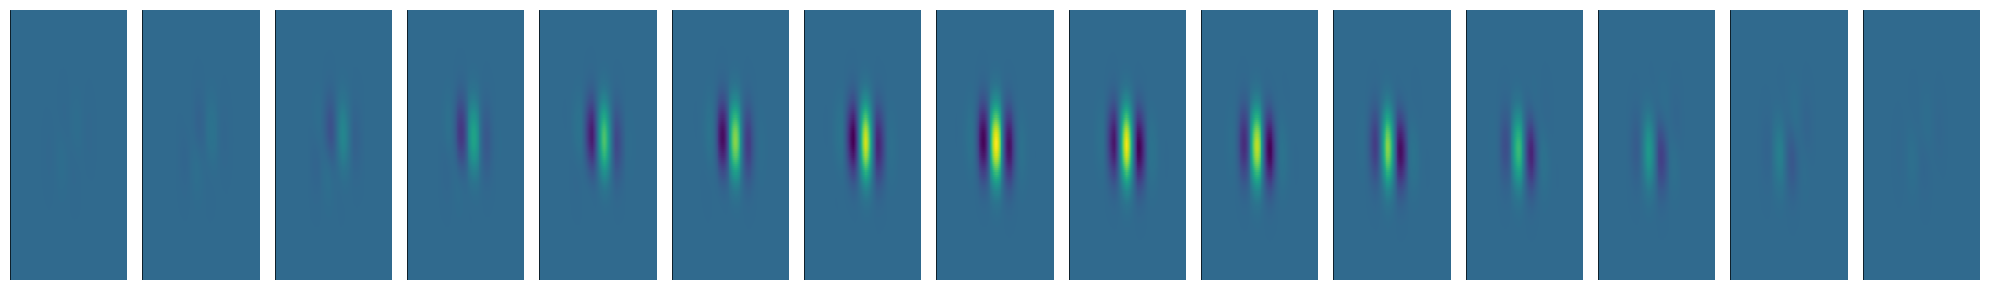

torch.Size([40, 128, 128])


In [7]:
fig = plt.figure(figsize=(20, 3))
afilter = filters['spatiotemporal']['re']['1-0-1']
nslicestot = afilter.shape[0]
vmin = torch.min(afilter)
vmax = torch.max(afilter)
nslices = 15
slices = np.linspace(0,nslicestot-1,nslices,dtype=int)
f=0
for i in slices:
    f+=1
    plt.subplot(1,nslices,f)
    plt.pcolormesh(afilter[i,:,:],vmin=vmin,vmax=vmax)
    plt.axhline(0,color='black',linewidth = 0.5) # x = 0
    plt.axvline(0,color='black',linewidth = 0.5) # y = 0
    plt.axis('off')
plt.tight_layout()
plt.show()
print(afilter.shape)

In [11]:
afilter.shape, movie.shape

(torch.Size([40, 128, 128]), torch.Size([1, 1, 80, 500, 500]))

## Convolve Filer Bank with Test Video

In [10]:
#pick the approrpiate one for this device
device = torch.device('cuda')
#device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
#device=('cpu')

movie = movie.to(device)

real_filters = []
imag_filters = []
real_outputs = []
imag_outputs = []
filter_names = list(filters['spatiotemporal']['re'].keys())
#loop thorugh filters
for filter_name in keys_subset: #filter_names:
    real_filter = filters['spatiotemporal']['re'][filter_name].unsqueeze(0).unsqueeze(0).float().to(device) #add another unsqueeze(0) for batch dim
    imag_filter = filters['spatiotemporal']['im'][filter_name].unsqueeze(0).unsqueeze(0).float().to(device)
    real_filters.append(real_filter)
    imag_filters.append(imag_filter)

    # Convolve in for loop - this is too slow. replace it with batched forward version.
    #full 3d
    real_conv = F.conv3d(movie, real_filter, padding='same')
    imag_conv = F.conv3d(movie, imag_filter, padding='same')    
    real_outputs.append(real_conv)
    imag_outputs.append(imag_conv)
    print('*',end='')
print('done')

real_filters = torch.stack(real_filters)
imag_filters = torch.stack(imag_filters)
real_outputs = torch.stack(real_outputs)
imag_outputs = torch.stack(imag_outputs)

/state/partition1/slurm_tmp/26743335.0.0/ipykernel_266936/1945869124.py:22: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  real_conv = F.conv3d(movie, real_filter, padding='same')


****done


In [12]:
# import torch
# import torch.nn.functional as F

# def separable_convolution_3d(movie, conv_filter):
#     # Ensure movie is a tensor with correct shape
#     if len(movie.shape) != 5 or len(conv_filter.shape) != 5:
#         raise ValueError("Input shapes are not correct. Movie should be BCDHW and conv_filter should be BCDHW")

#     # Extract the 1D filters from the 3D filter
#     conv_filter_x = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]
#     conv_filter_y = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]
#     conv_filter_z = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]

#     # Perform 1D convolution along each dimension
#     # X dimension
#     movie = movie.permute(0, 2, 1, 3, 4)  # Shape: [B, D, C, H, W]
#     movie = movie.reshape(movie.shape[0] * movie.shape[1], movie.shape[2], -1)  # Shape: [B*D, C, H*W]
#     conv_x = F.conv1d(movie, conv_filter_x, padding=conv_filter_x.size(-1) // 2)
#     conv_x = conv_x.reshape(-1, movie.shape[1], conv_x.shape[-1] // movie.shape[2], movie.shape[2])  # Shape: [B*D, C, H, W]
#     conv_x = conv_x.permute(0, 2, 1, 3)  # Shape: [B*D, H, C, W]
#     conv_x = conv_x.reshape(-1, conv_x.shape[2], conv_x.shape[1] * conv_x.shape[3])  # Shape: [B*D*H, C, W]

#     # Y dimension
#     conv_y = F.conv1d(conv_x, conv_filter_y, padding=conv_filter_y.size(-1) // 2)
#     conv_y = conv_y.reshape(-1, conv_x.shape[1], conv_y.shape[-1] // conv_x.shape[2], conv_x.shape[2])  # Shape: [B*D*H, C, W, H]
#     conv_y = conv_y.permute(0, 2, 1, 3)  # Shape: [B*D*H, W, C, H]
#     conv_y = conv_y.reshape(-1, conv_y.shape[2], conv_y.shape[1] * conv_y.shape[3])  # Shape: [B*D*H*W, C, H]

#     # Z dimension
#     conv_z = F.conv1d(conv_y, conv_filter_z, padding=conv_filter_z.size(-1) // 2)
#     conv_z = conv_z.reshape(-1, conv_y.shape[1], conv_z.shape[-1] // conv_y.shape[2], conv_y.shape[2])  # Shape: [B*D*H*W, C, H, D]
#     conv_z = conv_z.permute(0, 2, 1, 3)  # Shape: [B*D*H*W, H, C, D]
#     conv_z = conv_z.reshape(movie.shape[0], movie.shape[1], conv_z.shape[1], conv_z.shape[2], conv_z.shape[3])  # Shape: [B, D, H, C, W]

#     return conv_z.permute(0, 3, 1, 2, 4)  # Shape: [B, C, D, H, W]

# # Example usage
# movie = torch.randn(1, 1, 201, 200, 200)
# conv_filter = torch.randn(1, 1, 30, 30, 30)
# output = separable_convolution_3d(movie, conv_filter)
# print(output.shape)


In [13]:
#code to print output as images

# for i in range(len(real_output)):
    
#     fig = plt.figure(figsize=(20, 3))
#     output = real_output[i]
#     nslicestot = output.shape[0]
#     vmin = torch.min(output)
#     vmax = torch.max(output)
#     nslices = 15
#     slices = np.linspace(0,nslicestot-1,nslices,dtype=int)
#     f=0
#     for i in slices:
#         f+=1
#         plt.subplot(1,nslices,f)
#         # print(output.shape)
#         plt.pcolormesh(output[0,0,i,:,:].cpu().numpy(),vmin=vmin,vmax=vmax)
#         #plt.axhline(0,color='black',linewidth = 0.5) # x = 0
#         #plt.axvline(0,color='black',linewidth = 0.5) # y = 0
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [14]:
nslicestot

40

In [13]:
real_filter.shape

torch.Size([1, 1, 40, 128, 128])

1-0-1
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)


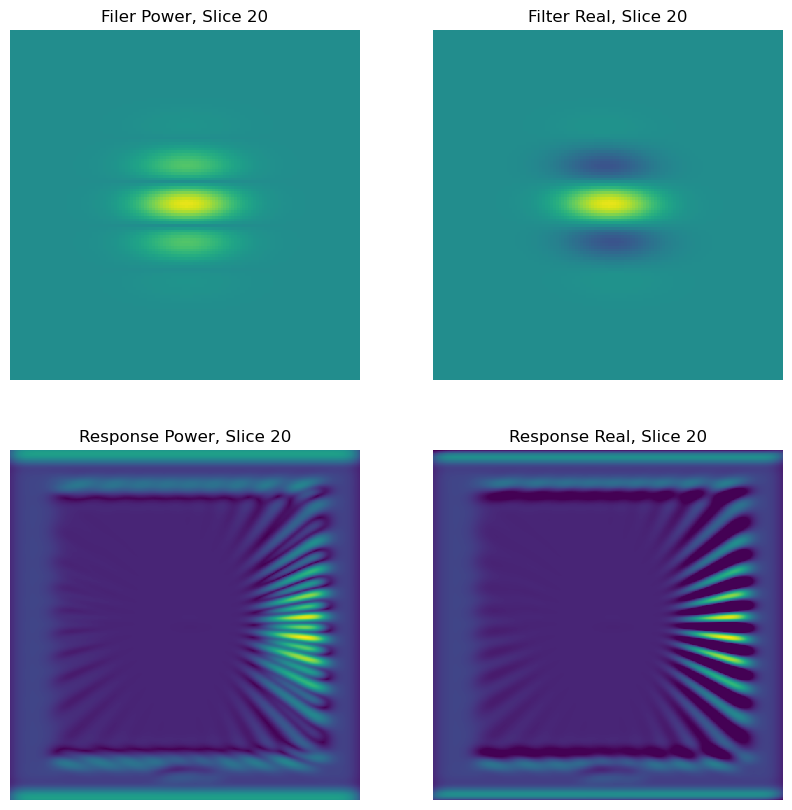

(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
1-0-2
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)


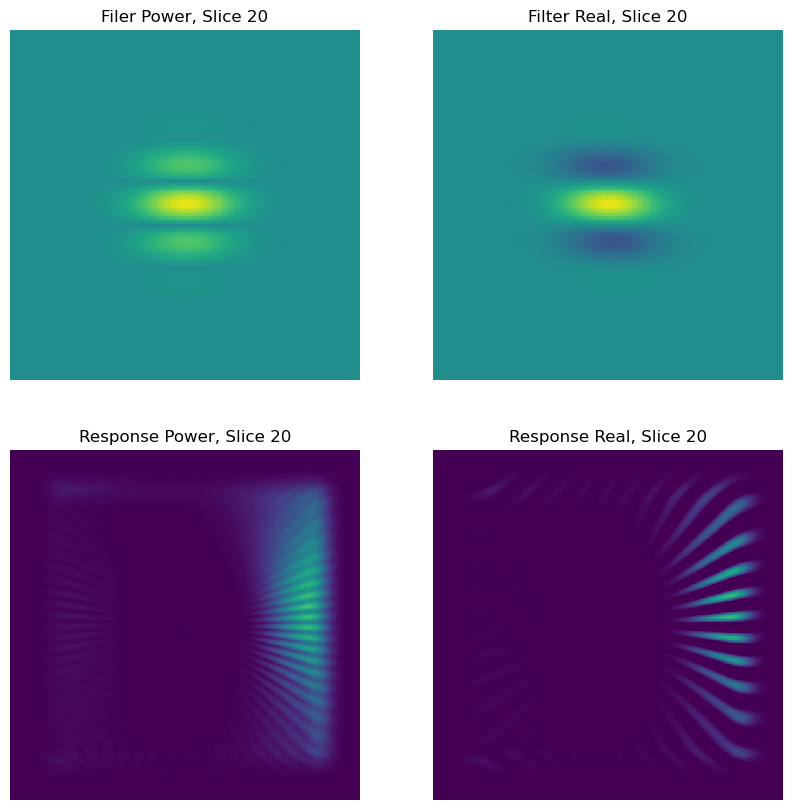

(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
1-0-4
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)


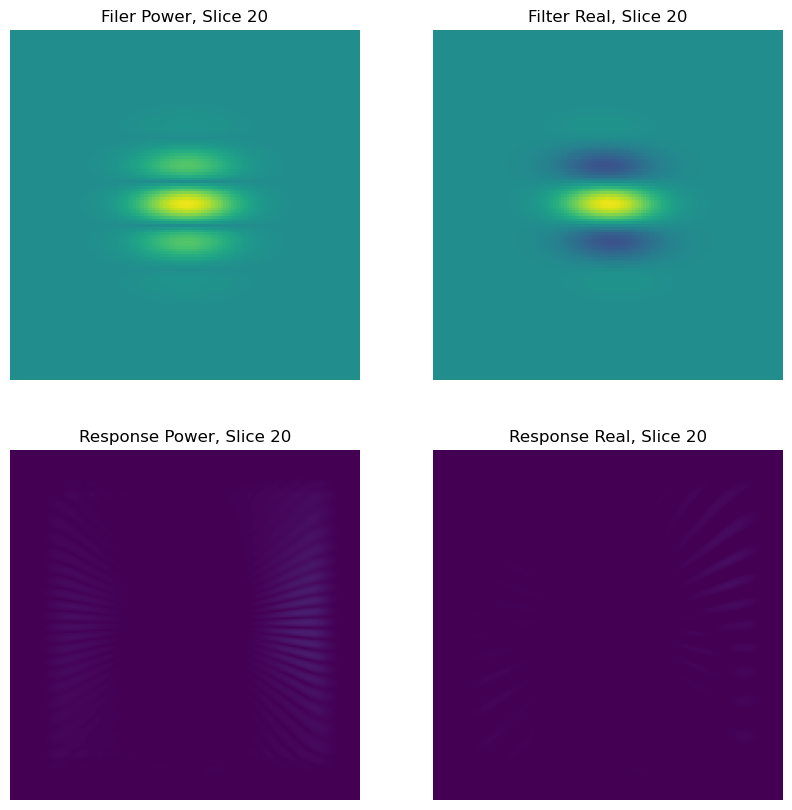

(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
1-0-8
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)


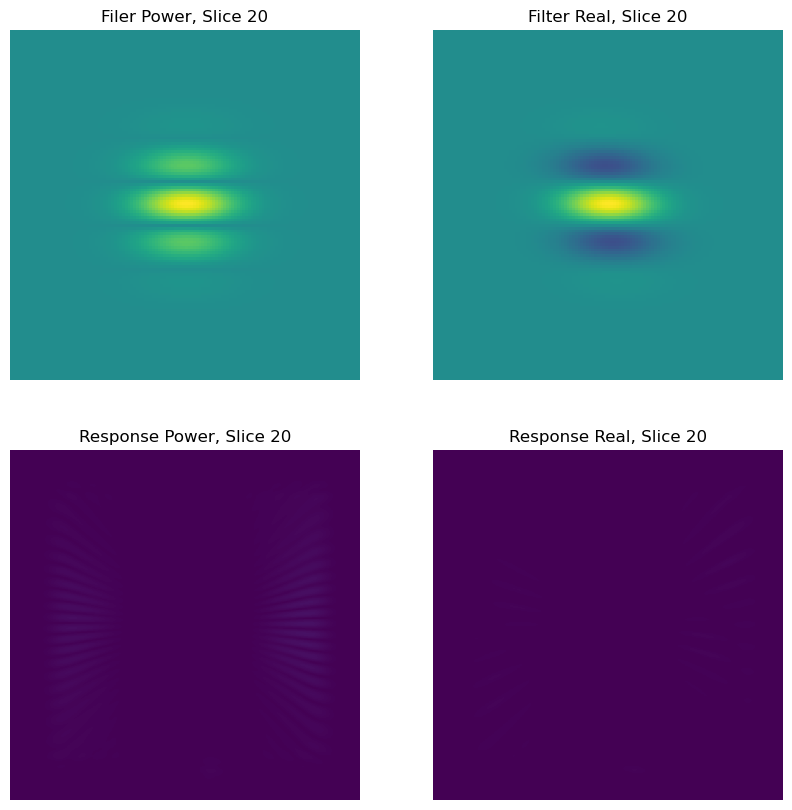

(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)
(1, 1, 40, 128, 128)


In [ ]:
import matplotlib.animation as animation
import os
from IPython.display import Video

# Create output directory
output_dir = f'test_movies_output_norm{normalize}_{filter_banks_size}'
os.makedirs(output_dir, exist_ok=True)

def create_movie(filter_real, filter_imag, output_real, output_imag, filename, fmin=None, fmax=None,rmin=None, rmax=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    nslices = nslicestot
    slices = np.linspace(0, nslices-1, nslices, dtype=int)

    def update_plot(frame):
        slice_idx = slices[frame]
        axes[0,0].clear()
        axes[0,1].clear()
        axes[1,0].clear()
        axes[1,1].clear()
        #Filter
        print(filter_real.shape)
        axes[0,0].pcolormesh(np.real(np.sqrt(filter_real[0,0,slice_idx,:,:]**2 + filter_imag[0,0,slice_idx,:,:]**2)),vmin=fmin,vmax=fmax)
        axes[0,0].set_aspect('equal')
        axes[0,0].set_title(f'Filer Power, Slice {slice_idx}')
        axes[0,1].pcolormesh(filter_real[0,0,slice_idx,:,:],vmin=fmin,vmax=fmax)
        axes[0,1].set_aspect('equal')
        axes[0,1].set_title(f'Filter Real, Slice {slice_idx}')
       
        #Response
        #axes[1,0].pcolormesh(output_real[0,0,slice_idx,:,:])#, vmin=vmin, vmax=vmax)
        axes[1,0].pcolormesh(np.real(np.sqrt(output_real[0,0,slice_idx,:,:]**2 + output_imag[0,0,slice_idx,:,:]**2)),vmin=rmin,vmax=rmax)
        axes[1,0].set_aspect('equal')
        axes[1,0].set_title(f'Response Power, Slice {slice_idx}')
        axes[1,1].pcolormesh(output_real[0,0,slice_idx,:,:],vmin=rmin,vmax=rmax)#, vmin=vmin, vmax=vmax)
        axes[1,1].set_aspect('equal')
        axes[1,1].set_title(f'Response Real, Slice {slice_idx}')
        for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]:
            # ax.axhline(0, color='black',linewidth = 0.25) # x = 0
            # ax.axvline(0, color='black',linewidth = 0.25) # y = 0
            ax.axis('off')
        if(frame==nslices//2):
            plt.show()

    ani = animation.FuncAnimation(fig, update_plot, frames=nslices, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=30)
    plt.close(fig)

fmin = np.min((real_filters.cpu().numpy(), imag_filters.cpu().numpy()))
fmax = np.max((real_filters.cpu().numpy(), imag_filters.cpu().numpy()))
pow = np.real(np.sqrt(real_outputs.cpu().numpy()**2 + imag_outputs.cpu().numpy()**2))
rmin = np.min(pow)
rmax = np.max(pow)

for i in range(len(real_outputs)):

    filter_real = real_filters[i].cpu().numpy()
    filter_imag = imag_filters[i].cpu().numpy()
    output_real = real_outputs[i].cpu().numpy()
    output_imag = imag_outputs[i].cpu().numpy()

    print(filter_names[i])
    #print(output_real.shape)
    #print(output_imag.shape)
    
    filename = os.path.join(output_dir, f'test_response_{filter_names[i]}.mp4')
    create_movie(filter_real, filter_imag, output_real, output_imag, filename,fmin=fmin, fmax=fmax,rmin=rmin, rmax=rmax)
#show the last video
Video(filename)